In [27]:
import glob
import os
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

# Load the contents
with open("train_metrics_20251016_0639.jsonl", "r") as f:
    train_metrics = [json.loads(line) for line in f]

df_metrics = pd.DataFrame(train_metrics)
df_metrics

,step,train_loss,val_loss,hellaswag_acc,norm,tokens_per_second,lr,shard_index
0,0,11.086510,11.057925,NaN,0.000000,1626.444291,0.000000,0
1,16,11.069857,NaN,NaN,7.852065,31720.863844,0.000002,0
2,32,10.965048,NaN,NaN,7.860700,46572.015194,0.000003,0
3,48,10.615686,NaN,NaN,7.568923,50512.499025,0.000005,0
4,64,10.356436,NaN,NaN,7.159593,50226.926820,0.000006,0
...,...,...,...,...,...,...,...,...
2827,45232,3.366496,NaN,NaN,0.428380,49639.494569,0.000191,7
2828,45248,3.322927,NaN,NaN,0.451934,49697.435439,0.000191,7
2829,45264,3.092568,NaN,NaN,0.429490,49385.995411,0.000191,7
2830,45280,3.319700,NaN,NaN,0.427662,49200.927562,0.000191,7


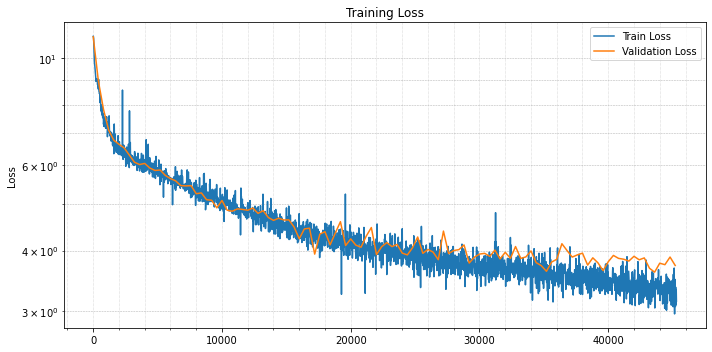

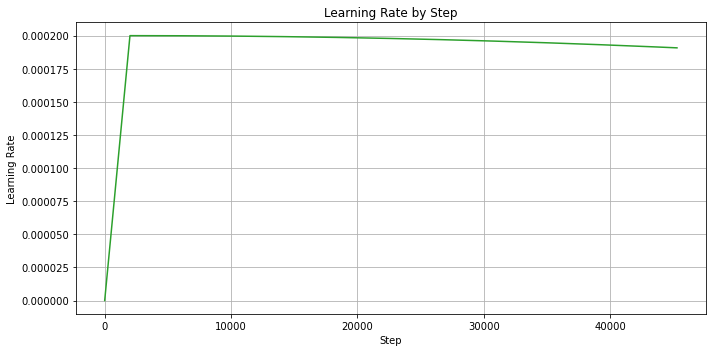

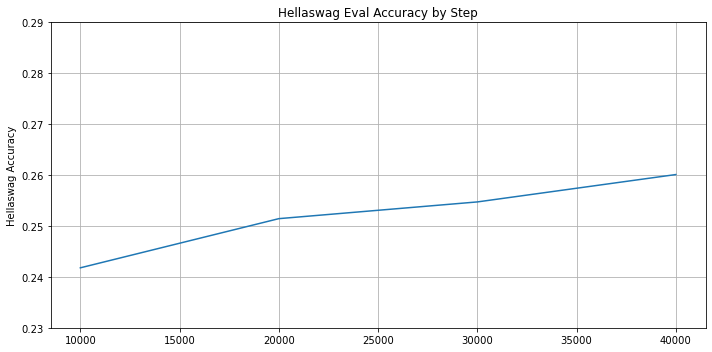

In [28]:
# Training Loss Figure
fig1, ax1 = plt.subplots(figsize=(10, 5), facecolor="white")
ax1.plot(
    df_metrics["step"], df_metrics["train_loss"], color="tab:blue", label="Train Loss"
)
ax1.plot(
    df_metrics["step"][df_metrics["val_loss"].notna()],
    df_metrics["val_loss"][df_metrics["val_loss"].notna()],
    color="tab:orange",
    label="Validation Loss",
    zorder=4,
)
ax1.legend()
ax1.yaxis.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.xaxis.set_major_locator(mticker.AutoLocator())
ax1.xaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.xaxis.grid(True, which="both", linestyle=":", linewidth=0.5)
ax1.set_yscale("log")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.grid(True)
fig1.patch.set_facecolor("white")
plt.tight_layout()
plt.show()

# Learning Rate Figure
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(df_metrics["step"], df_metrics["lr"], color="tab:green")
ax2.set_xlabel("Step")
ax2.set_ylabel("Learning Rate")
ax2.set_title("Learning Rate by Step")
ax2.grid(True)
plt.tight_layout()
plt.show()

# Hellaswag Eval Accuracy Figure
fig3, ax3 = plt.subplots(figsize=(10, 5))
ax3.plot(
    df_metrics["step"][df_metrics["hellaswag_acc"].notna()],
    df_metrics["hellaswag_acc"][df_metrics["hellaswag_acc"].notna()],
    color="tab:blue",
)
ax3.set_ylabel("Hellaswag Accuracy")
ax3.set_title("Hellaswag Eval Accuracy by Step")
ax3.grid(True)
ax3.set_ylim(bottom=0.23, top=0.29)
plt.tight_layout()
plt.show()

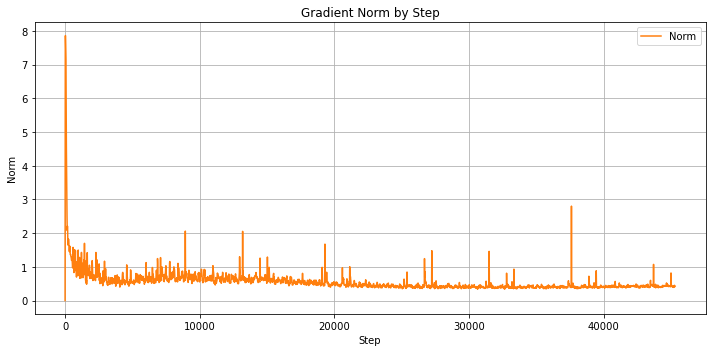

In [29]:
# Plot Norm
fig_norm, ax_norm = plt.subplots(figsize=(10, 5))
ax_norm.plot(df_metrics["step"], df_metrics["norm"], color="tab:orange", label="Norm")
ax_norm.set_xlabel("Step")
ax_norm.set_ylabel("Norm")
ax_norm.set_title("Gradient Norm by Step")
ax_norm.grid(True)
ax_norm.legend()
plt.tight_layout()
plt.show()

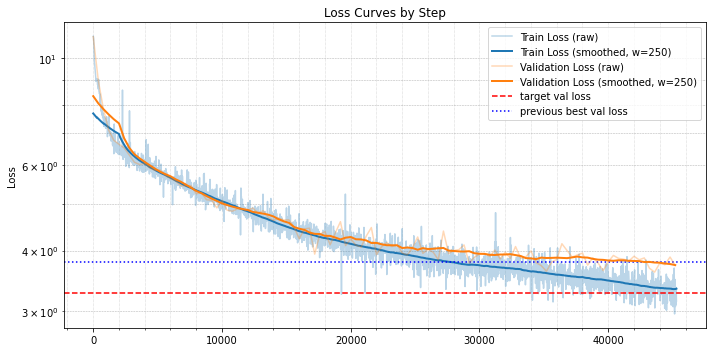

In [30]:
# Smooth Training + Validation Loss (rolling window) and plot
fig1, ax1 = plt.subplots(figsize=(10, 5), facecolor="white")

n = len(df_metrics)
window = 250

# centered rolling mean (keeps alignment)
train_smooth = df_metrics["train_loss"].rolling(window=window, min_periods=1, center=True).mean()

val_mask = df_metrics["val_loss"].notna()
val_series = df_metrics["val_loss"].copy()

# compute rolling mean only where val exists
val_smooth = val_series.rolling(window=window, min_periods=1, center=True).mean()

# plot raw (faded) and smoothed (solid)
ax1.plot(df_metrics["step"], df_metrics["train_loss"], color="tab:blue", alpha=0.3, label="Train Loss (raw)")
ax1.plot(df_metrics["step"], train_smooth, color="tab:blue", linewidth=2, label=f"Train Loss (smoothed, w={window})")

ax1.plot(
    df_metrics["step"][val_mask],
    df_metrics["val_loss"][val_mask],
    color="tab:orange",
    alpha=0.3,
    label="Validation Loss (raw)",
    zorder=3,
)
ax1.plot(
    df_metrics["step"][val_mask],
    val_smooth[val_mask],
    color="tab:orange",
    linewidth=2,
    label=f"Validation Loss (smoothed, w={window})",
    zorder=4,
)
ax1.axhline(y=3.28, color='r', linestyle='--', label='target val loss')
ax1.axhline(y=3.8, color='blue', linestyle='dotted', label='previous best val loss')



ax1.legend()
ax1.yaxis.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.xaxis.set_major_locator(mticker.AutoLocator())
ax1.xaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.xaxis.grid(True, which="both", linestyle=":", linewidth=0.5)
ax1.set_yscale("log")
ax1.set_ylabel("Loss")
ax1.set_title("Loss Curves by Step")
ax1.grid(True)
fig1.patch.set_facecolor("white")
plt.tight_layout()
plt.show()